In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine

pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="dsa3101-435110")

amazon_df = pd.read_csv("amazon.csv")

/Users/brandon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Q1


What are the key factors influencing customer purchasing behavior?

- Analyze historical sales data to identify patterns and trends.
- <strong>Develop customer segmentation models based on purchasing behavior. (Not done)</strong>


### Type of purchases and revenue by month


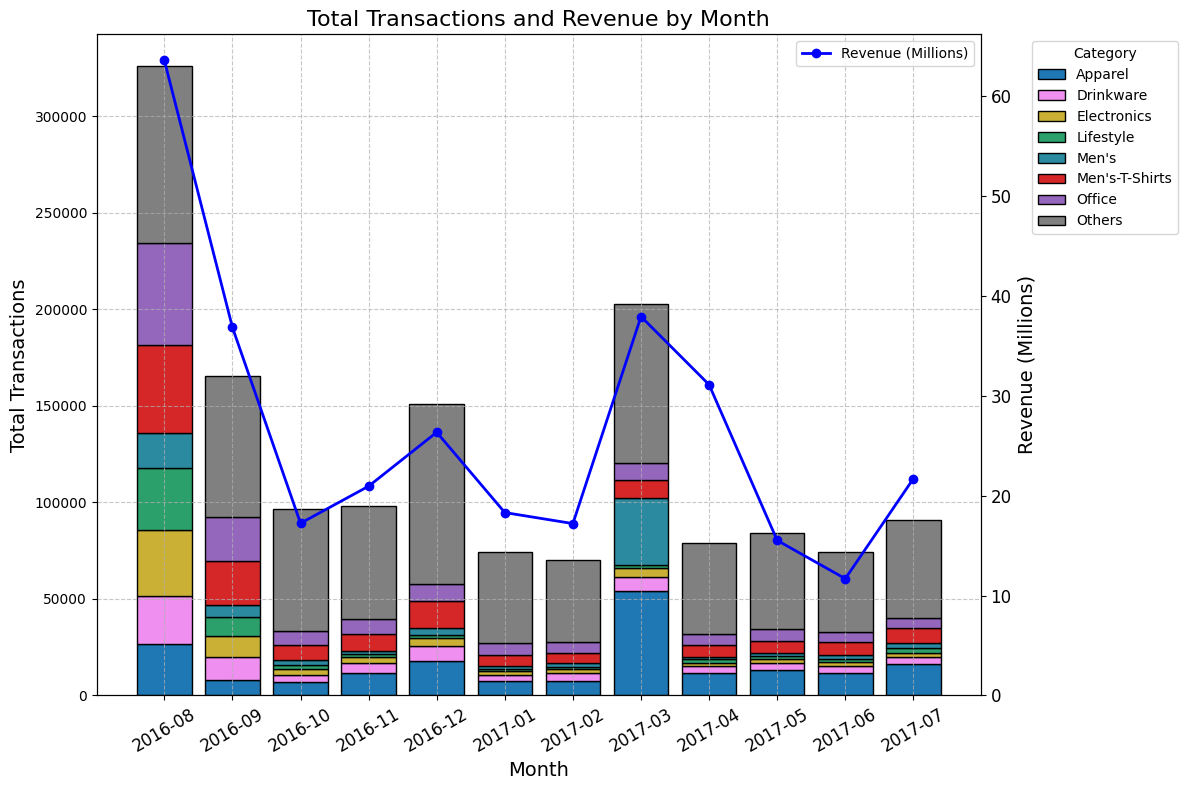

In [3]:
query = """
        SELECT FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS MONTH, product.v2ProductCategory AS Category, SUM(totals.transactions) AS TotalTransactions, SUM(totals.totalTransactionRevenue) AS TotalRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        GROUP BY MONTH, Category
        HAVING TotalTransactions > 0
        ORDER BY MONTH, Category
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Extract the sub category
result_df['Category'] = result_df['Category'].apply(
    lambda x: x.split("/")[-1] if x.split("/")[-1] != "" else x.split("/")[-2])

# Remove unformatted categories
result_df = result_df.query("Category not in ['(not set)', '${escCatTitle}']")

# Since '2017-08' only contains 1 day of data
result_df = result_df.query("MONTH < '2017-08'")

# Extract the top 5 categories
top_categories = result_df.groupby(
    'Category')['TotalTransactions'].sum().nlargest(7).index

# Create a new column for categories
result_df['Category'] = result_df['Category'].apply(
    lambda x: x if x in top_categories else 'Others'
)

# Pivot the DataFrame to wide format
pivot_df = result_df.pivot_table(
    index='MONTH', columns='Category', values=['TotalTransactions', 'TotalRevenue'], aggfunc='sum', fill_value=0)


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Initialize the bottom parameter
bottoms = [0] * len(pivot_df)

# Define colors
category_colors = {
    'Apparel': '#1f77b4',  # Blue
    'Drinkware': '#EF8FEF',  # Pink
    'Electronics': '#CAB136',  # Khaki
    'Lifestyle': '#2BA06B',  # Forest green
    "Men's": '#2B89A0',   # Turquoise
    "Men's-T-Shirts": '#d62728',   # Red
    'Office': '#9467bd',   # Purple
    'Others': '#808080'  # Gray for 'Other'
}

# Plot the stacked bar chart on the primary y-axis
for category, color in category_colors.items():
    if category in pivot_df.TotalTransactions.columns:
        ax1.bar(pivot_df.index, pivot_df.TotalTransactions[category], bottom=bottoms,
                label=category, color=color, edgecolor='black')
        bottoms = [bottoms[j] + pivot_df.TotalTransactions[category].iloc[j]
                   for j in range(len(bottoms))]

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(pivot_df.index, pivot_df.TotalRevenue.sum(axis=1)/1e12, marker='o',
         color='b', linestyle='-', linewidth=2, label='Revenue (Millions)')

# Add labels and titles
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Total Transactions', fontsize=14)
ax1.set_title('Total Transactions and Revenue by Month', fontsize=16)
ax1.tick_params(axis='x', rotation=30, labelsize=12)
ax1.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_ylabel('Revenue (Millions)', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper right')
ax2.set_ylim(bottom=0)

# Add a grid
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

2016-08: Large number of transactions throughout all Categories

2017-03: There is a large increase in transactions for Men's and Apparel items.


### Exit rate by Page Title


Exit rates are the lowest when items from a specific category are being displayed


### Bounce rates by Page Title


In [46]:
# Bounce rate by pages
query = f"""
        SELECT hits.page.pageTitle AS PageTitle, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS BounceRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits
        WHERE hits.type = 'PAGE' AND hits.hitNumber = 1
        GROUP BY PageTitle
        ORDER BY Views DESC
        LIMIT 10
        """
rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

/Users/brandonwoo/Desktop/GenAI/GenAI.backend/GenAI.Backend/.conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                                           PageTitle   Views  BounceRate
0                                Google Online Store  339352    0.592002
1                                               Home  275170    0.374627
2  YouTube | Shop by Brand | Google Merchandise S...   79314    0.563873
3  Men's T-Shirts | Apparel | Google Merchandise ...   26342    0.465758
4              The Google Merchandise Store - Log In   16321    0.361191
5                                   Page Unavailable   15965    0.404447
6                                      Shopping Cart    9428    0.454709
7  Men's Outerwear | Apparel | Google Merchandise...    7439    0.436618
8                    Bags | Google Merchandise Store    6928    0.460450
9               Drinkware | Google Merchandise Store    6834    0.557799 



RFM (Recency, Frequency, Monetary) analysis is used to segment the customers before running behaviour-based clustering algorithm () to automatically find customer groups


In [37]:
query = f"""
    -- Selecting the neccessary columns for RMF analysis
    WITH testingData AS (
        SELECT
            visitNumber,
            fullVisitorId AS visitorId,
            geoNetwork,
            totals,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            IF(totals.transactions >= 0, totals.transactions, 0) AS transactions,
            IF(totals.transactionRevenue >= 0, totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            date != "None"
        ORDER BY
            visitorID,
            visitNumber
    ),
    -- calculate recency score by calculating the number of days since last purchase
    recencyScore AS (
        SELECT
            visitorId,
            DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
        FROM
            testingData
        GROUP BY
            visitorId
    ),
    -- Creating a new column of the next purchase date by taking date from next row for the customer
    leadData AS (
        SELECT
            LEAD(date, 1)
            OVER (PARTITION BY
                    visitorId
                ORDER BY
                    visitorId,
                    visitNumber
                )
            AS nextDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM
            testingData
    ),
    -- Set next day to be null when for the latest transaction
    fixedLeadData AS (
        SELECT
            COALESCE(nextDate, CURRENT_DATE()) AS nextDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM
            leadData
    ),
    -- Calculate the number of days between data and next date columns
    frequencyData AS (
        SELECT
            testingData.visitorId,
            DATE_DIFF(lead.date, lead.nextDate, DAY) AS diffDays
        FROM
            testingData
        INNER JOIN
            fixedLeadData lead
        ON
            testingData.visitorId = lead.visitorId AND testingData.visitNumber = lead.visitNumber
    ),
    -- Calculate the average number of days inbetween purchases
    frequencyScore AS (
        SELECT
            visitorId,
            AVG(diffDays) AS frequency
        FROM
            frequencyData
        GROUP BY
            visitorId
    ),
    -- Calculate the total transaction every customer spent
    monetaryScore AS (
        SELECT
            visitorId,
            SUM(transactionRevenue) AS monetary
        FROM
            testingData
        GROUP BY
            visitorId
    ),
    -- Combining all the score tables into one table
    rmftable AS (
        SELECT
           r.visitorId,
           r.recency,
           f.frequency,
           m.monetary,
        FROM
            recencyScore AS r
        JOIN
            frequencyScore AS f
        ON
            r.visitorId = f.visitorId
        JOIN
            monetaryScore AS m
        ON
            m.visitorId = r.visitorId
    ),
    -- Split each score into 4 quartiles as bins
    rmfScore AS (
        SELECT
            visitorId,
            NTILE(4) OVER (ORDER BY recency ASC) AS recency_score,
            NTILE(4) OVER (ORDER BY frequency DESC) AS frequency_score,
            NTILE(4) OVER (ORDER BY monetary DESC) AS monetary_score,
        FROM
            rmftable
    )

    -- Calculate the total score by summing all the inidividual scores
    SELECT
        visitorId,
        (recency_score + frequency_score + monetary_score) AS totalScore
    FROM
        rmfScore
    """
rows = client.query(query)

result_df = rows.to_dataframe()

/Users/brandon/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


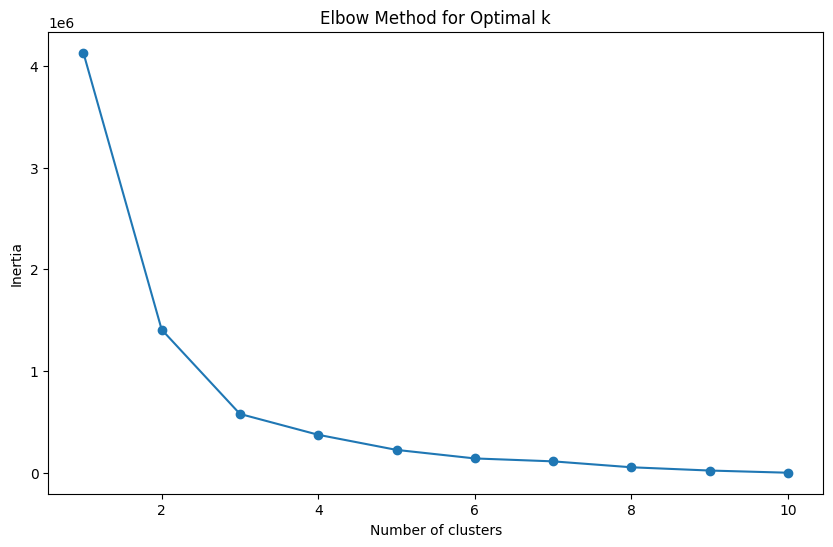

In [38]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(result_df["totalScore"].to_frame())
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [35]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
result_df['cluster'] = kmeans.fit_predict(result_df["totalScore"].to_frame())

In [36]:
# Aggregate cluster information
cluster_summary = result_df.groupby('cluster').agg({
    'totalScore': ['mean', 'std'],
    'visitorId': 'count'
})

print(cluster_summary)

        totalScore           visitorId
              mean       std     count
cluster                               
0         7.956774    0.8315    283878
1          4.95353   1.00971    264042
2        10.764435  0.822223    166247


# Q2


How can we improve customer retention and lifetime value?

- Calculate customer churn rates and identify at-risk customers.
- Analyze the effectiveness of current retention strategies.


### Calculating yearly churn rates


In [3]:
query = f"""
        SELECT
            fullVisitorID,
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS CustomerPurchaseCount,
            trafficSource.source AS TrafficSource,
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930' AND
            hits.eCommerceAction.action_type = '6'
        GROUP BY fullVisitorID, Channel, TrafficSource
        ORDER BY CustomerPurchaseCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

/Users/brandonwoo/Desktop/GenAI/GenAI.backend/GenAI.Backend/.conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         fullVisitorID         Channel  TotalRevenue  CustomerPurchaseCount TrafficSource
0  8851822767477687842        Referral   30878760000                     96      (direct)
1   666582393118140484        Referral   20600080000                     68      (direct)
2  3033366073043100694        Referral   11512000000                     60      (direct)
3  5689475961693395998        Referral   15128780000                     54      (direct)
4  9377429831454005466  Organic Search   20728520000                     52        google
5  8436426603099391262        Referral   37197920000                     52      (direct)
6  5632276788326171571          Direct  673375500000                     42      (direct)
7  4923243433046835289          Direct   14585600000                     40      (direct)
8  5912152563864160997        Referral    9040400000                     40      (direct)
9  6374969976921419865          Direct    7172800000                     40      (direct) 



The most popular channel that is used by customers with a high purchase count


In [11]:
# https://medium.com/octave-john-keells-group/a-simple-six-step-approach-to-define-customer-churn-in-retail-f401e31e57c0#:~:text=Identifying%20the%20point%20in%20which,time%20to%20proactively%20implement%20interventions.&text=Step%206%3A,is%20identified%20as%20a%20churner.
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Select only the latest date for each visitor and check for their churn status
        RankedDates AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                LowerBoundOneMonthLag,
                ROW_NUMBER() OVER (
                    PARTITION BY fullVisitorID
                    ORDER BY Date DESC
                ) AS rn
            FROM LaggingThreshold
        )

        SELECT Date, fullVisitorID, DailyPurchaseCount, OneMonthMA, LowerBound, LowerBoundOneMonthLag
        FROM RankedDates
        ORDER BY Date
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Sum of purchases by each visitor
grouped_sum = result_df.groupby('fullVisitorID')[
    'DailyPurchaseCount'].sum().reset_index()

grouped_sum = grouped_sum.rename(
    columns={'DailyPurchaseCount': 'HistoricPurchases'})

df = result_df.merge(grouped_sum, on='fullVisitorID',
                     how='left').query("HistoricPurchases > 0")

df['Date'] = pd.to_datetime(df['Date'])

# Only keep the entry of the last purchase
latest_idx = df.groupby('fullVisitorID')['Date'].idxmax()

result_df = df.loc[latest_idx].sort_values(by="Date")

print(result_df, "\n")

             Date        fullVisitorID  DailyPurchaseCount  OneMonthMA  LowerBound  LowerBoundOneMonthLag  HistoricPurchases
1282   2016-08-01  5760753352577829144                  79    2.633333    2.633333                    0.0                 79
710    2016-08-01  6569605994631186947                  36    1.200000    1.200000                    0.0                 36
653    2016-08-01  2125540555068339394                  25    0.833333    0.833333                    0.0                 25
26     2016-08-01  7589137567725941774                  51    1.700000    1.700000                    0.0                 51
192    2016-08-01  5563168194966233133                  21    0.700000    0.700000                    0.0                 21
...           ...                  ...                 ...         ...         ...                    ...                ...
833207 2017-08-01   024507252193437459                  16    0.533333    0.406213                    0.0                 16


In [12]:
# Those that have not made a purchase within the last 3 months or have a monthly moving average less than the lower bound have a retention risk
max_date = result_df['Date'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
RetentionRiskCount = len(set(result_df.query(
    "Date <= @three_months_ago | LowerBoundOneMonthLag >= OneMonthMA").fullVisitorID))

# Those that have made a purchase within the last 3 months or have a monthly moving average more than the lower bound do not have a retention risk
RetentionCount = len(set(result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA").fullVisitorID))


result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA")

,Date,fullVisitorID,DailyPurchaseCount,OneMonthMA,LowerBound,LowerBoundOneMonthLag,HistoricPurchases
650466,2017-05-01,536428604379922267,22,0.733333,0.733333,0.0,22
651761,2017-05-01,1749853719127085935,13,0.433333,0.433333,0.0,13
652127,2017-05-01,9740050408987139130,19,0.633333,0.633333,0.0,19
651220,2017-05-01,9565722193439879038,11,0.366667,0.279271,0.0,11
650623,2017-05-01,4501448098783068461,22,2.466667,1.636650,0.0,74
...,...,...,...,...,...,...,...
833207,2017-08-01,024507252193437459,16,0.533333,0.406213,0.0,16
833325,2017-08-01,5199370466032130686,0,0.866667,0.428464,0.0,26
834246,2017-08-01,3614707430894059857,28,0.933333,0.933333,0.0,28
835152,2017-08-01,9591202457292182670,20,0.666667,0.157052,0.0,20


These are the at risk customers as the lagged lower bound is greater or equal to their one month moving average on purchase count


In [9]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those with a retention risk: Less than threshold or have not purchased within the last 3 months
        RetentionRisk AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag >= lt.OneMonthMA AND lt.Date < (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                RetentionRisk
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            RetentionRisk,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          4419         43.154297
1  Organic Search          2360         23.046875
2         Display          1668         16.289062
3          Direct          1455         14.208984
4     Paid Search           239          2.333984
5          Social            96          0.937500
6      Affiliates             3          0.029297
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [8]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those without a retention risk: More than threshold or have purchased within the last 3 months
        Retention AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag < lt.OneMonthMA AND lt.Date >= (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                Retention
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            Retention,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          3695         39.812520
1          Direct          2193         23.628919
2  Organic Search          2133         22.982437
3         Display           884          9.524836
4     Paid Search           307          3.307833
5          Social            63          0.678806
6      Affiliates             6          0.064648
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [13]:
ChurnRate = (RetentionRiskCount /
             (RetentionRiskCount + RetentionCount)) * 100

print("The churn rate for google online store is :", round(ChurnRate, 4), "% \n")

The churn rate for google online store is : 69.2704 % 



### Evaluating current retention strategies


In [52]:

# https://medium.com/@busegungor2303/calculation-of-cltv-and-prediction-of-cltv-71c4f754dd90
query = f"""
        SELECT COALESCE(totals.totalTransactionRevenue, 0)/1e6 AS TotalRevenueInMillions, COALESCE(totals.transactions) AS Transactions, fullVisitorId
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Only for those where transactions > 0 since we are looking at customers and not visitors
sub_df = result_df.query("Transactions > 0")
sub_df = sub_df.groupby("fullVisitorId").sum()
sub_df['AvgOrderValue'] = sub_df.TotalRevenueInMillions / sub_df.Transactions

print(sub_df.sort_values("AvgOrderValue").query("AvgOrderValue > 0"), '\n')

AvgCustomerValue = sub_df.TotalRevenueInMillions.sum() / len(sub_df)
# The average value of a customer that purchases
print("Customer value is: ", round(AvgCustomerValue, 5), 'Millions \n')

# The likelihood of a customer making a second purchase
AvgRepeatRate = len(sub_df.query("Transactions > 1")) / len(sub_df)
print("Repeat rate is: ", round(AvgRepeatRate*100, 4), '% \n')

                     TotalRevenueInMillions  Transactions  AvgOrderValue
fullVisitorId                                                           
9367883304718826385                    1.20             1            1.2
3568593840277988902                    3.01             2          1.505
0136876972401975041                    2.04             1           2.04
3073830805992104825                    2.49             1           2.49
7161524936078300347                    2.50             1            2.5
...                                     ...           ...            ...
7965265156545901045                 4849.60             1         4849.6
5469079519715865124                 5608.40             1         5608.4
1957458976293878100               128412.52            22    5836.932727
7496147812697146114                 7003.50             1         7003.5
5632276788326171571                16032.75             1       16032.75

[9996 rows x 3 columns] 

Customer value is:  177.

In [54]:
# Repeat rate for valuable customers
val_sub_df = sub_df.query(f"AvgOrderValue > {AvgCustomerValue}")
val_RepeatRate = len(val_sub_df.query("Transactions > 1")) / len(val_sub_df)

print(f"The repeat rate for valuable customers is: 
      {round(val_RepeatRate*100, 4)}", '% \n')

The repeat rate for valuable customers is: 24.4152 % 



Since the repeat rate for valuable customers is greater then the average (24% > 11.6%), current retention strategies are effective in retaining valuable customers.


# Q3


What are the most effective marketing channels and campaigns?

- Evaluate the ROI of different marketing channels.

- Analyze the impact of various promotional campaigns on sales - Ads & Promotion position


### Evalutaing revenue of different marketing channels


In [93]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            trafficSource.source AS TrafficSource,
            COUNT(fullVisitorID) AS UserCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type != '0'
        GROUP BY TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel         TrafficSource  UserCount
0  Organic Search                google     339732
1        Referral              (direct)     338334
2          Direct              (direct)     234482
3  Organic Search              (direct)     197849
4     Paid Search                google      29673
5          Social           youtube.com      26201
6     Paid Search              (direct)      21580
7         Display                   dfa      14255
8      Affiliates              Partners      10965
9        Referral  analytics.google.com       6205 



Using the dataframe above, we can find which platform and channel is the most popular.


In [96]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS UserCount,
            SUM(totals.totalTransactionRevenue/1e6) / COUNT(fullVisitorID) AS AVGRevenuePerUserInMilllions,
            trafficSource.source AS TrafficSource,
            CASE
                WHEN hits.eCommerceAction.action_type = '1' THEN 'Click product lists'
                WHEN hits.eCommerceAction.action_type = '2' THEN 'View product details'
                WHEN hits.eCommerceAction.action_type = '3' THEN 'Add to cart'
                WHEN hits.eCommerceAction.action_type = '4' THEN 'Remove from cart'
                WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
                WHEN hits.eCommerceAction.action_type = '6' THEN 'Purchase'
                WHEN hits.eCommerceAction.action_type = '7' THEN 'Refund'
                WHEN hits.eCommerceAction.action_type = '0' THEN 'Unknown'
            END AS Action
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type = '6'
        GROUP BY Action, TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

           Channel   TotalRevenue  UserCount  AVGRevenuePerUserInMilllions            TrafficSource    Action
0         Referral  6861093620000      32354                    212.063226                 (direct)  Purchase
1           Direct  9231074220000      14684                    628.648476                 (direct)  Purchase
2   Organic Search  3403071550000      13419                    253.600980                   google  Purchase
3   Organic Search  1709765760000       7592                    225.206238                 (direct)  Purchase
4      Paid Search   361601340000       1628                    222.113845                   google  Purchase
5      Paid Search   207373340000       1296                    160.010293                 (direct)  Purchase
6          Display  4605551900000       1010                   4559.952376                      dfa  Purchase
7         Referral   374165040000        578                    647.344360          mail.google.com  Purchase
8         

Referral searches via a direct traffic source attracts the greatest number of users.

However, the display channel via the dfa traffic source generates the greatest revenue per user.


In [97]:
# For each page title, find the number of customers and the way people are able to search for their products -> Which is the most effective
query = f"""
        SELECT
            IF(LENGTH(hits.page.pageTitle) <= 20, hits.page.pageTitle, CONCAT(SUBSTR(hits.page.pageTitle, 1, 20), '...')) AS PageTitle,
            channelGrouping AS Channel,
            COUNT(fullVisitorID) AS VisitorCount,
            SUM(IF(totals.transactions IS NULL, 0, totals.transactions)) AS TransactionCount,
            SUM(totals.totalTransactionRevenue/1e6) AS TotalRevenueInMillions
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.page.pageTitle NOT LIKE '%Checkout%'
            AND hits.page.pageTitle NOT LIKE '%Home%'
            AND hits.page.pageTitle NOT LIKE '%Cart%'
            AND hits.page.pageTitle NOT LIKE '%Google%'
            AND hits.page.pageTitle NOT LIKE '%Payment%'
            AND hits.page.pageTitle NOT LIKE '%results%'
        GROUP BY PageTitle, Channel
        ORDER BY VisitorCount DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

           PageTitle         Channel  VisitorCount  TransactionCount  TotalRevenue
0     Men's-T-Shirts  Organic Search         31922              2698     410113.98
1             Office  Organic Search         22441              2107     339173.57
2   Page Unavailable        Referral         21349               499      66833.21
3               Bags  Organic Search         19002              1288     415953.97
4        Electronics  Organic Search         18657              2486     873982.35
5          Drinkware  Organic Search         17328              1861     519384.35
6     Men's-T-Shirts        Referral         14478              3573     493624.68
7            Apparel  Organic Search         12960               899     263526.79
8          Lifestyle  Organic Search         12844              1428     221770.16
9               Bags        Referral         11839              1474     304820.03
10            Office        Referral         11747              2691     737288.10
11  

Referral and organic searches are clearly the most popular traffic channels and a higher traffic generally equates to a higher transaction count
